# Comparison of TidalPy to Guo+ (2004) and Farrell (1972)
Using both TidalPy's compressible and incompressible methods.

Benchmarks originally created by Nick Wagner (Baylor U.) in 2024.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from TidalPy.RadialSolver import radial_solver, build_rs_input_from_data
from TidalPy.rheology import Elastic

## Guo+ (2004) Comparison
Recreate results of Guo+ 2004 (https://academic.oup.com/gji/article/159/1/53/1996045)
Uses PREM model of Earth with averaged continental and ocean crust
LNs taken from table 1 of Guo+ 2004 GJI

In [47]:
# Load data and other physical properties
guo_data = np.load("Guo+2004.npy")

# Pull out columns and convert to SI
radius_array  = guo_data[:, 0] * 1000.
density_array = guo_data[:, 1] * 1000.
vs            = guo_data[:, 2] * 1000.
vp            = guo_data[:, 3] * 1000.

# Convert Seismic Velocities to Elastic Moduli
shear_array          = vs**2 * density_array
bulk_mod_array       = (vp**2 * density_array) - (4. / 3.) * shear_array
lame                 = bulk_mod_array - (2. / 3.) * shear_array
viscosity_array      = 1.0e30 * np.ones_like(shear_array)  # This is unused while the shear rheology is elastic
bulk_viscosity_array = viscosity_array                     # This is unused while the bulk rheology is elastic

# Define planetary parameters
forcing_frequency   = 2. * np.pi / (24 * 60 * 60)  # [rad s-1]
planet_mass         = 5.972e24                     # [kg]
planet_radius       = 6.3710e+06                   # [m]
surface_pressure    = 0.0                          # [Pa]
planet_volume       = (4. / 3.) * np.pi * (planet_radius**3)
planet_bulk_density = planet_mass / planet_volume

icb_radius = 1.2225e+06
cmb_radius = 3.4810e+06

upper_radius_by_layer     = (icb_radius, cmb_radius, planet_radius)
layer_types               = ("solid", "liquid", "solid")
is_static_bylayer         = (False, True, False)
is_incompressible_bylayer = (True, True, True)
is_compressible_bylayer   = (False, False, False)
shear_rheologies          = (Elastic(), Elastic(), Elastic())
bulk_rheologies           = (Elastic(), Elastic(), Elastic())

# Use TidalPy's helper function for data arrays to ensure they are in the correct format
rs_input_incompressible = build_rs_input_from_data(
    forcing_frequency,
    radius_array,
    density_array,
    bulk_mod_array,
    shear_array,
    bulk_viscosity_array,
    viscosity_array,
    upper_radius_by_layer,
    layer_types,
    is_static_bylayer,
    is_incompressible_bylayer,
    shear_rheologies,
    bulk_rheologies,
    perform_checks=True,
    warnings=True)

# Repeat for compressible case
rs_input_compressible = build_rs_input_from_data(
    forcing_frequency,
    radius_array,
    density_array,
    bulk_mod_array,
    shear_array,
    bulk_viscosity_array,
    viscosity_array,
    upper_radius_by_layer,
    layer_types,
    is_static_bylayer,
    is_compressible_bylayer,
    shear_rheologies,
    bulk_rheologies,
    perform_checks=True,
    warnings=True)

2025-01-03 11:26:45(+00:47:30::532566) - WARNING  : Radius array must start at zero, inserting r=0.0 at slice 0; other parameters will be set to their values at previous slice 0.
2025-01-03 11:26:45(+00:47:30::532566) - WARNING  : Radius array must start at zero, inserting r=0.0 at slice 0; other parameters will be set to their values at previous slice 0.


In [56]:
# Solve for the Love numbers for multiple degree l's

other_rs_inputs = dict(
    surface_pressure         = surface_pressure,
    solve_for                = ('tidal', 'loading'),
    starting_radius          = 0.1,
    start_radius_tolerance   = 1.0e-5,
    integration_method       = 'RK45',
    integration_rtol         = 1.0e-8,
    integration_atol         = 1.0e-12,
    scale_rtols_bylayer_type = False,
    max_num_steps            = 1_500_000,
    expected_size            = 1000,
    max_ram_MB               = 4000,
    max_step                 = 0,
    nondimensionalize        = True,
    use_prop_matrix          = False,
    verbose                  = False,
    warnings                 = False,
    raise_on_fail            = False,
    eos_method_bylayer       = None,
    eos_integration_method   = 'DOP853',
    eos_rtol                 = 1.0e-8,
    eos_atol                 = 1.0e-14,
    eos_pressure_tol         = 1.0e-2,
    eos_max_iters            = 350,
    perform_checks           = True,
    log_info                 = False
)

nmax=18
min_l = 1
degs = np.arange(min_l, nmax + min_l)
kp_i = np.full(nmax, np.nan, dtype=np.complex128)
hp_i = np.full(nmax, np.nan, dtype=np.complex128)
kl_i = np.full(nmax, np.nan, dtype=np.complex128)
hl_i = np.full(nmax, np.nan, dtype=np.complex128)

kp_c = np.full(nmax, np.nan, dtype=np.complex128)
hp_c = np.full(nmax, np.nan, dtype=np.complex128)
kl_c = np.full(nmax, np.nan, dtype=np.complex128)
hl_c = np.full(nmax, np.nan, dtype=np.complex128)

for di, degree_l in enumerate(degs):
    if degree_l == degs[-1]:
        print(f"Working on l =   {degree_l}.", end='\n')
    else:
        print(f"Working on l =   {degree_l}.", end='\r')

    radial_solution_incomp = \
        radial_solver(
            *rs_input_incompressible,
            degree_l=degree_l,
            use_kamata=True,
            **other_rs_inputs
            )
    if not radial_solution_incomp.success:
        # The incompressible solution must use the kamata starting conditions because, 
        # as of v0.6.0, TidalPy does not have an incompressible TS74-based starting condition.
        # But, Kamata's starting conditions (specifically for solution #3) fail when degree = 1.
        # So we will just not be able to so an incompressible result for l=1 for incompressible.
        # If you wanted to get a sense of what it may look like, you can set the inner core to compressible and turn
        # use_kamata=False.

        pass
        # print(radial_solution_incomp.message)
        # raise Exception(f"Incompressible Solver Failed at l = {degree_l}.")
    else:
        if degree_l==1:
            kp_i[di] = radial_solution_incomp.k[0]-radial_solution_incomp.k[0]
            hp_i[di] = radial_solution_incomp.h[0]-radial_solution_incomp.k[0]
            kl_i[di] = radial_solution_incomp.k[1]-radial_solution_incomp.k[1]
            hl_i[di] = radial_solution_incomp.h[1]-radial_solution_incomp.k[1]
        else:
            kp_i[di] = radial_solution_incomp.k[0]
            hp_i[di] = radial_solution_incomp.h[0]
            kl_i[di] = radial_solution_incomp.k[1]
            hl_i[di] = radial_solution_incomp.h[1]
    
    radial_solution_compress = \
        radial_solver(
            *rs_input_compressible,
            degree_l=degree_l,
            use_kamata=False,
            **other_rs_inputs
            )

    if not radial_solution_compress.success:
        print(radial_solution_incomp.message)
        # raise Exception(f"Compressible Solver Failed at l = {degree_l}.")
    else:
        if degree_l==1:
            kp_c[di] = radial_solution_compress.k[0]-radial_solution_compress.k[0]
            hp_c[di] = radial_solution_compress.h[0]-radial_solution_compress.k[0]
            kl_c[di] = radial_solution_compress.k[1]-radial_solution_compress.k[1]
            hl_c[di] = radial_solution_compress.h[1]-radial_solution_compress.k[1]
        else:
            kp_c[di] = radial_solution_compress.k[0]
            hp_c[di] = radial_solution_compress.h[0]
            kl_c[di] = radial_solution_compress.k[1]
            hl_c[di] = radial_solution_compress.h[1]
    
print("Done!")

Working on l =   18.
Done!


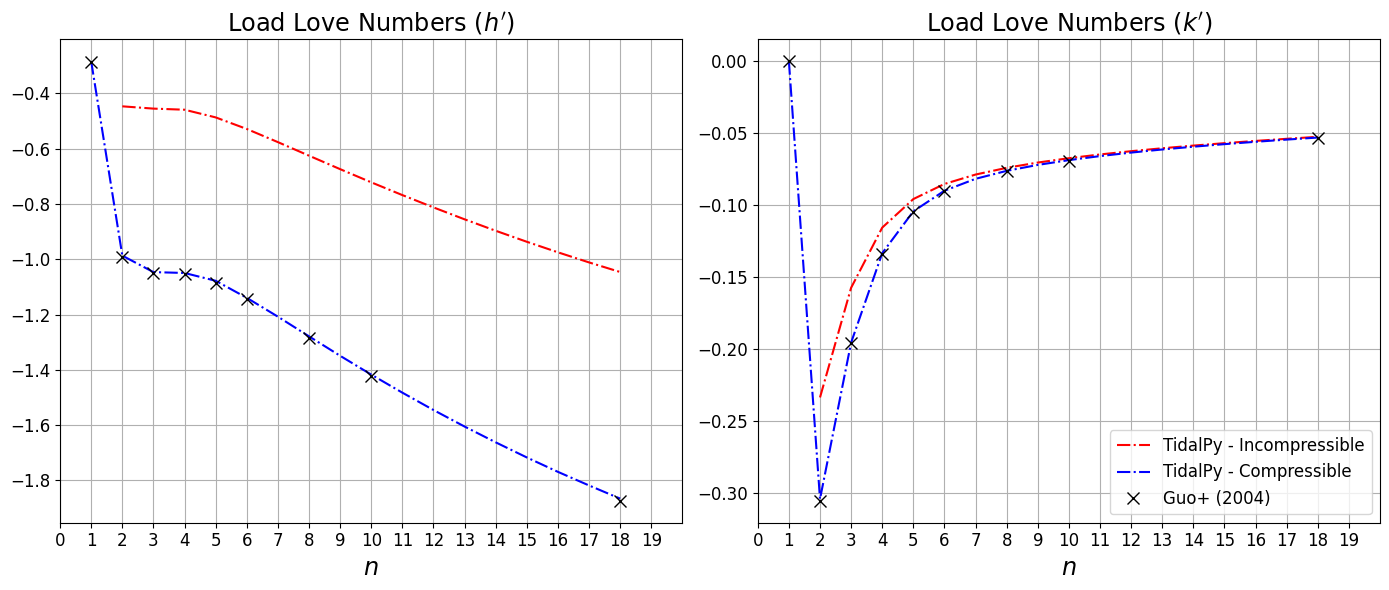

In [85]:
# Plot Results
guo_n  = np.array([1, 2, 3, 4, 5, 6, 8, 10, 18])
guo_h  = -np.array([0.2856, 0.9909, 1.0501, 1.0528, 1.0857, 1.1433, 1.2833, 1.4226, 1.8733])
guo_kn = -np.array([0, 0.6103, 0.5876, 0.5341, 0.5228, 0.5411, 0.61107, 0.6893, 0.961])

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(degs,hl_i,'-.',label="TidalPy - Incompressible",ms=8,color='red')
plt.plot(degs,hl_c,'-.',label="TidalPy - Compressible",ms=8,color='blue')
plt.plot(guo_n,guo_h,'x',label="Guo+ (2004)",ms=8,color='black')
plt.xticks(np.arange(0, nmax + min_l + 1, 1))
plt.xlim([0, nmax + min_l + 1])
plt.tick_params(labelsize='large')
plt.title('Load Love Numbers $(h^\prime)$',fontsize = 'xx-large')
plt.xlabel('$n$',fontsize='xx-large')
plt.grid()

plt.subplot(1,2,2)
plt.plot(degs,kl_i,'-.',label="TidalPy - Incompressible",ms=8,color='red')
plt.plot(degs,kl_c,'-.',label="TidalPy - Compressible",ms=8,color='blue')
plt.plot(guo_n,guo_kn/guo_n,'x',label="Guo+ (2004)",ms=8,color='black')

plt.xticks(np.arange(0, nmax + min_l + 1, 1))
plt.xlim([0, nmax + min_l + 1])
plt.tick_params(labelsize='large')

plt.legend(loc='lower right',fontsize='12',ncol=1)
plt.title('Load Love Numbers $(k^\prime)$',fontsize = 'xx-large')
plt.xlabel('$n$',fontsize='xx-large')
plt.grid()
plt.tight_layout()
plt.show()
    

## Farrell (1972) Comparison
Now lets do an older model, from Farrell (1972) using the Gutenberg Earth model of Alterman+ 1961

In [103]:
# Now lets do an older model, from Farrell (1972) using the Gutenberg Earth model of Alterman+ 1961
farrell_data = np.load("Farrell1972.npy")

# Pull out columns and convert to SI
radius_array_f72  = farrell_data[:, 0] * 1000.
density_array_f72 = farrell_data[:, 1] * 1000.
vs_f72            = farrell_data[:, 2] * 1000.
vp_f72            = farrell_data[:, 3] * 1000.

# Convert Seismic Velocities to Elastic Moduli
shear_array_f72          = vs_f72**2 * density_array_f72
bulk_mod_array_f72       = (vp_f72**2 * density_array_f72) - (4. / 3.) * shear_array_f72
lame_f72                 = bulk_mod_array_f72 - (2. / 3.) * shear_array_f72
viscosity_array_f72      = 1.0e30 * np.ones_like(shear_array_f72)  # This is unused while the shear rheology is elastic
bulk_viscosity_array_f72 = viscosity_array_f72                     # This is unused while the bulk rheology is elastic

# Define planetary parameters
forcing_frequency_f72   = 2. * np.pi / (24 * 60 * 60)  # [rad s-1]
planet_mass_f72         = 5.972e24                     # [kg]
planet_radius_f72       = radius_array_f72[-1]         # [m]
surface_pressure_f72    = 0.0                          # [Pa]
planet_volume_f72       = (4. / 3.) * np.pi * (planet_radius**3)
planet_bulk_density_f72 = planet_mass / planet_volume

# icb_radius_f72 = 1.2225e+06
cmb_radius_f72 = 3.473e+06

upper_radius_by_layer_f72     = (cmb_radius_f72, planet_radius_f72)
layer_types_f72               = ("liquid", "solid")
is_static_bylayer_f72         = (True, False)
is_incompressible_bylayer_f72 = (True, True)
is_compressible_bylayer_f72   = (False, False)
shear_rheologies_f72          = (Elastic(), Elastic())
bulk_rheologies_f72           = (Elastic(), Elastic())

# Use TidalPy's helper function for data arrays to ensure they are in the correct format
rs_input_incompressible_f72 = build_rs_input_from_data(
    forcing_frequency_f72,
    radius_array_f72,
    density_array_f72,
    bulk_mod_array_f72,
    shear_array_f72,
    bulk_viscosity_array_f72,
    viscosity_array_f72,
    upper_radius_by_layer_f72,
    layer_types_f72,
    is_static_bylayer_f72,
    is_incompressible_bylayer_f72,
    shear_rheologies_f72,
    bulk_rheologies_f72,
    perform_checks=True,
    warnings=True)

# Repeat for compressible case
rs_input_compressible_f72 = build_rs_input_from_data(
    forcing_frequency_f72,
    radius_array_f72,
    density_array_f72,
    bulk_mod_array_f72,
    shear_array_f72,
    bulk_viscosity_array_f72,
    viscosity_array_f72,
    upper_radius_by_layer_f72,
    layer_types_f72,
    is_static_bylayer_f72,
    is_compressible_bylayer_f72,
    shear_rheologies_f72,
    bulk_rheologies_f72,
    perform_checks=True,
    warnings=True)

2025-01-03 12:07:13(+01:27:58::367110) - WARNING  : Radius array must start at zero, inserting r=0.0 at slice 0; other parameters will be set to their values at previous slice 0.
2025-01-03 12:07:13(+01:27:58::367110) - WARNING  : Layer 1 starts at a different radius value than the previous layer's upper radius. Interface radius values must be provided twice, once for each layer above and below the interface. This radius value will be added; other parameters will be set to their values at the slice just after this upper radius value.
2025-01-03 12:07:13(+01:27:58::367110) - WARNING  : Radius array must start at zero, inserting r=0.0 at slice 0; other parameters will be set to their values at previous slice 0.
2025-01-03 12:07:13(+01:27:58::367110) - WARNING  : Layer 1 starts at a different radius value than the previous layer's upper radius. Interface radius values must be provided twice, once for each layer above and below the interface. This radius value will be added; other paramete

In [104]:
other_rs_inputs_f72 = dict(
    surface_pressure         = surface_pressure,
    solve_for                = ('tidal', 'loading'),
    starting_radius          = 0.1,
    start_radius_tolerance   = 1.0e-5,
    integration_method       = 'RK45',
    integration_rtol         = 1.0e-8,
    integration_atol         = 1.0e-12,
    scale_rtols_bylayer_type = False,
    max_num_steps            = 1_500_000,
    expected_size            = 1000,
    max_ram_MB               = 4000,
    max_step                 = 0,
    nondimensionalize        = True,
    use_prop_matrix          = False,
    verbose                  = False,
    warnings                 = False,
    raise_on_fail            = False,
    eos_method_bylayer       = None,
    eos_integration_method   = 'RK45',
    eos_rtol                 = 1.0e-8,
    eos_atol                 = 1.0e-14,
    eos_pressure_tol         = 1.0e-2,
    eos_max_iters            = 350,
    perform_checks           = True,
    log_info                 = False
)


nmax=18
min_l = 1
degs = np.arange(min_l, nmax + min_l)

kp_i_f72 = np.full(nmax, np.nan, dtype=np.complex128)
hp_i_f72 = np.full(nmax, np.nan, dtype=np.complex128)
kl_i_f72 = np.full(nmax, np.nan, dtype=np.complex128)
hl_i_f72 = np.full(nmax, np.nan, dtype=np.complex128)

kp_c_f72 = np.full(nmax, np.nan, dtype=np.complex128)
hp_c_f72 = np.full(nmax, np.nan, dtype=np.complex128)
kl_c_f72 = np.full(nmax, np.nan, dtype=np.complex128)
hl_c_f72 = np.full(nmax, np.nan, dtype=np.complex128)

for di, degree_l in enumerate(degs):
    if degree_l == degs[-1]:
        print(f"Working on l =   {degree_l}.", end='\n')
    else:
        print(f"Working on l =   {degree_l}.", end='\r')

    radial_solution_incomp = \
        radial_solver(
            *rs_input_incompressible_f72,
            degree_l=degree_l,
            use_kamata=True,
            **other_rs_inputs_f72
            )
    if not radial_solution_incomp.success:
        # The incompressible solution must use the kamata starting conditions because, 
        # as of v0.6.0, TidalPy does not have an incompressible TS74-based starting condition.
        # But, Kamata's starting conditions (specifically for solution #3) fail when degree = 1.
        # So we will just not be able to so an incompressible result for l=1 for incompressible.
        # If you wanted to get a sense of what it may look like, you can set the inner core to compressible and turn
        # use_kamata=False.

        pass
        # print(radial_solution_incomp.message)
        # raise Exception(f"Incompressible Solver Failed at l = {degree_l}.")
    else:
        if degree_l==1:
            kp_i_f72[di] = radial_solution_incomp.k[0]-radial_solution_incomp.k[0]
            hp_i_f72[di] = radial_solution_incomp.h[0]-radial_solution_incomp.k[0]
            kl_i_f72[di] = radial_solution_incomp.k[1]-radial_solution_incomp.k[1]
            hl_i_f72[di] = radial_solution_incomp.h[1]-radial_solution_incomp.k[1]
        else:
            kp_i_f72[di] = radial_solution_incomp.k[0]
            hp_i_f72[di] = radial_solution_incomp.h[0]
            kl_i_f72[di] = radial_solution_incomp.k[1]
            hl_i_f72[di] = radial_solution_incomp.h[1]
    
    radial_solution_compress = \
        radial_solver(
            *rs_input_compressible_f72,
            degree_l=degree_l,
            use_kamata=False,
            **other_rs_inputs
            )

    if not radial_solution_compress.success:
        print(radial_solution_incomp.message)
        # raise Exception(f"Compressible Solver Failed at l = {degree_l}.")
    else:
        if degree_l==1:
            kp_c_f72[di] = radial_solution_compress.k[0]-radial_solution_compress.k[0]
            hp_c_f72[di] = radial_solution_compress.h[0]-radial_solution_compress.k[0]
            kl_c_f72[di] = radial_solution_compress.k[1]-radial_solution_compress.k[1]
            hl_c_f72[di] = radial_solution_compress.h[1]-radial_solution_compress.k[1]
        else:
            kp_c_f72[di] = radial_solution_compress.k[0]
            hp_c_f72[di] = radial_solution_compress.h[0]
            kl_c_f72[di] = radial_solution_compress.k[1]
            hl_c_f72[di] = radial_solution_compress.h[1]
    
print("Done!")

Working on l =   18.
Done!


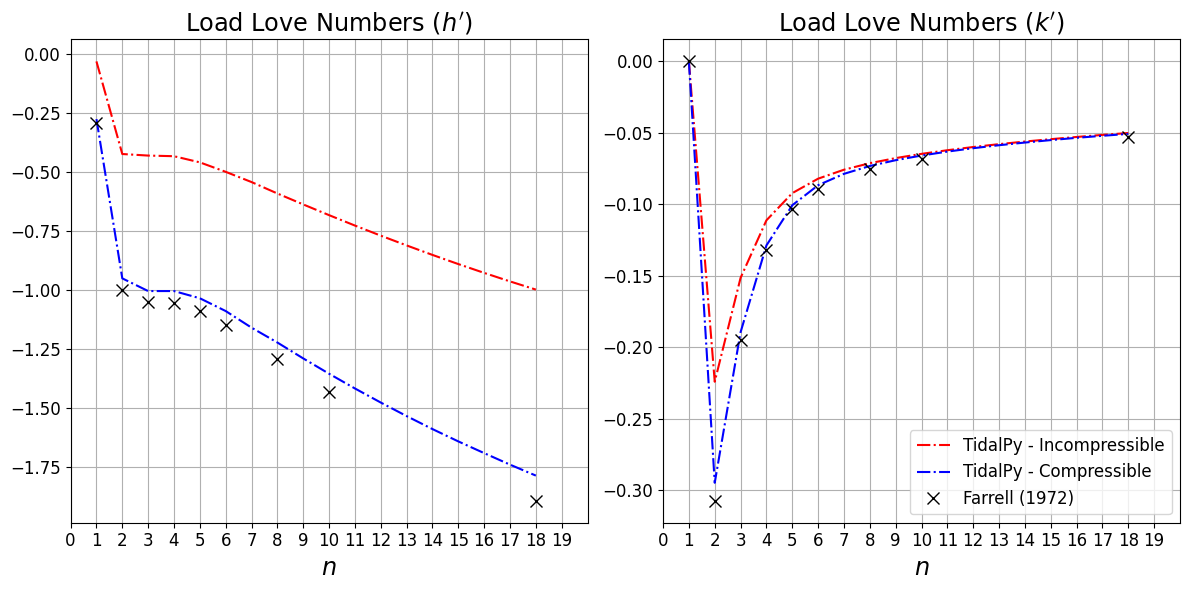

In [105]:
# Plot Results
alt_n_f72 = np.array([1, 2, 3, 4, 5, 6, 8, 10, 18])
alt_h_f72 = -np.array([0.29, 1.001, 1.052, 1.053, 1.088, 1.147, 1.291, 1.433, 1.893])
alt_kn_f72 = -np.array([0, 0.615, 0.585, 0.528, 0.516, 0.535, 0.604, 0.682, 0.952])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

# n1 = np.arange(0,11)
plt.plot(degs,hl_i_f72,'-.',label="TidalPy - Incompressible",ms=8,color='red')
plt.plot(degs,hl_c_f72,'-.',label="TidalPy - Compressible",ms=8,color='blue')
plt.plot(alt_n_f72,alt_h_f72,'x',label="Farrell (1972)",ms=8,color='black')
plt.xticks(np.arange(0, nmax + min_l + 1, 1))
plt.xlim([0, nmax + min_l + 1])
plt.tick_params(labelsize='large')
plt.title('Load Love Numbers $(h^\prime)$',fontsize = 'xx-large')
plt.xlabel('$n$',fontsize='xx-large')
plt.grid()



# Plot
plt.subplot(1,2,2)
plt.plot(degs,kl_i_f72,'-.',label="TidalPy - Incompressible",ms=8,color='red')
plt.plot(degs,kl_c_f72,'-.',label="TidalPy - Compressible",ms=8,color='blue')
plt.plot(alt_n_f72,alt_kn_f72/alt_n_f72,'x',label="Farrell (1972)",ms=8,color='black')
plt.xticks(np.arange(0, nmax + min_l + 1, 1))
plt.xlim([0, nmax + min_l + 1])
plt.tick_params(labelsize='large')
plt.legend(loc='lower right',fontsize='12',ncol=1)
plt.title('Load Love Numbers $(k^\prime)$',fontsize = 'xx-large')
plt.xlabel('$n$',fontsize='xx-large')
plt.grid()
plt.tight_layout()

plt.show()
 